### Assignment 3

Gender: Gender of the individual

Age: Age of the individual

Height: Height of the individual

Weight: Weight of the individual

family_istory_with_overweight: Whether the individual has a family member suffered or suffers from overweight

FAVC: Frequency of consuming high-calorie foods

FCVC: Frequency of of consuming vegetables

NCP: Number of main meals per day

CAEC: Frequency of eating any food between meals

SMOKE: Whether the individual smoke

CH2O: Amount of water consumed daily

SCC: Whether the individual monitors their daily calories

FAF: Frequency of having physical activity

TUE: Time using technological devices (cell phone, videogames, television, computer and others)

CALC: Frequency of consuming alcohol

MTRANS: Mode of transportation used by the individual (e.g., walking, biking, public transportation, etc.).

NObeyesdad: Obesity level

**Class Labels**

Insufficient Weight, Normal Weight, Overweight Level I, Overweight Level II, Obesity Type I, Obesity Type II, and Obesity Type III

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.svm import SVC
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from sklearn.pipeline import Pipeline

seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

In [2]:
df = pd.read_csv('estimation+of+obesity+levels+based+on+eating+habits+and+physical+condition\ObesityDataSet_raw_and_data_sinthetic.csv')

X = df.drop('NObeyesdad', axis=1)
y = df['NObeyesdad']

object_columns = X.select_dtypes(include=['object']).columns
bool_columns = X.select_dtypes(include=['bool']).columns
X[object_columns] = X[object_columns].astype('category')
X[bool_columns] = X[bool_columns].astype('category')
mapping_dict = {}

for col in X.select_dtypes(['category']).columns:
    mapping_dict[col] = dict(enumerate(X[col].cat.categories))
inverse_mapping_dict = {col: {v: k for k, v in mapping_dict[col].items()} for col in mapping_dict}

X[object_columns] = X[object_columns].apply(lambda x: x.cat.codes)
X[bool_columns] = X[bool_columns].apply(lambda x: x.cat.codes)

print(y)

np.random.seed(seed)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

0             Normal_Weight
1             Normal_Weight
2             Normal_Weight
3        Overweight_Level_I
4       Overweight_Level_II
               ...         
2106       Obesity_Type_III
2107       Obesity_Type_III
2108       Obesity_Type_III
2109       Obesity_Type_III
2110       Obesity_Type_III
Name: NObeyesdad, Length: 2111, dtype: object


In [3]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#### Method 1: Logistic Regression

The coefficients of the logistic regression model indicate the importance and influence of each feature on the obesity levels.

This helps identify which factors are significant predictors of obesity.

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Parameters: {'logistic__C': 100, 'logistic__penalty': 'l2', 'logistic__solver': 'lbfgs'}
Best Score: 0.941768208886853

Logistic Regression

Accuracy: 0.9668769716088328
Classification Report:
                      precision    recall  f1-score   support

Insufficient_Weight       0.93      1.00      0.97        86
      Normal_Weight       0.98      0.91      0.94        93
     Obesity_Type_I       0.99      0.98      0.99       102
    Obesity_Type_II       0.97      1.00      0.98        88
   Obesity_Type_III       1.00      0.99      0.99        98
 Overweight_Level_I       0.93      0.94      0.94        88
Overweight_Level_II       0.96      0.94      0.95        79

           accuracy                           0.97       634
          macro avg       0.97      0.97      0.97       634
       weighted avg       0.97      0.97      0.97       634

Confusion Matrix:
 [[ 86   0   0   0   0   0   0]
 [  6  85   0   0

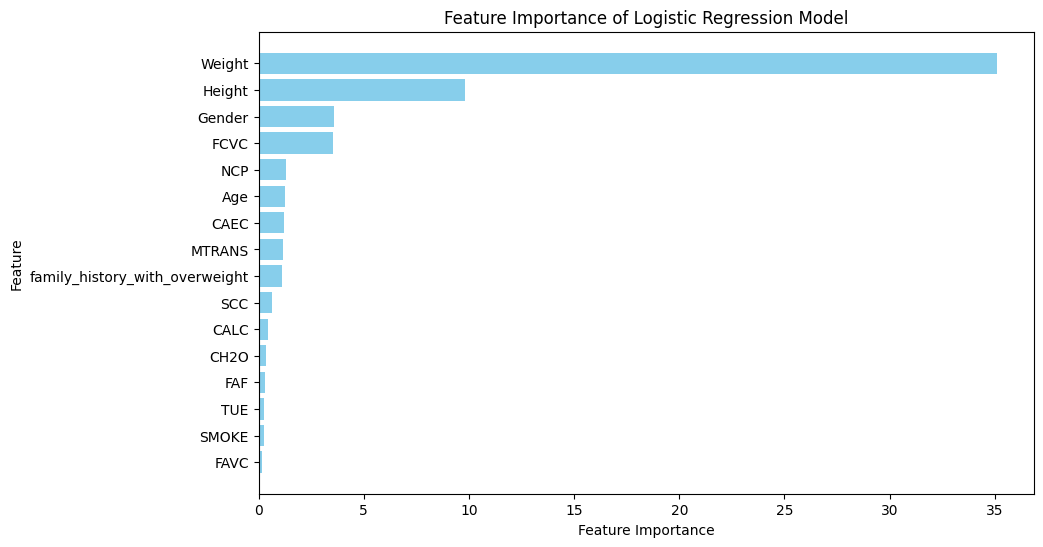

In [4]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logistic', LogisticRegression(max_iter=1000, random_state=42))
])

param_grid = {
    'logistic__C': [0.001, 0.01, 0.1, 1, 10, 100],  
    'logistic__penalty': ['l2'],  
    'logistic__solver': ['lbfgs']  
}

grid = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, verbose=1, scoring='accuracy',  n_jobs=-1)
grid_result = grid.fit(X_train, y_train)

print("Best Parameters:", grid_result.best_params_)
print("Best Score:", grid_result.best_score_)

best_params = grid_result.best_params_

best_log_reg = LogisticRegression(max_iter=1000, random_state=seed, C=best_params['logistic__C'], penalty=best_params['logistic__penalty'])

best_log_reg.fit(X_train, y_train)

y_pred_log = best_log_reg.predict(X_test)

print("\nLogistic Regression\n")
print("Accuracy:", accuracy_score(y_test, y_pred_log))
print("Classification Report:\n", classification_report(y_test, y_pred_log))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_log))
print("Coefficients:\n", pd.DataFrame(best_log_reg.coef_.T, X.columns, columns=best_log_reg.classes_))

total_coefficients = np.sum(np.abs(best_log_reg.coef_), axis=0)/y.nunique()
sorted_indices = np.argsort(total_coefficients)
sorted_coefficients = total_coefficients[sorted_indices]
sorted_feature_names = X.columns[sorted_indices]

plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names, sorted_coefficients, color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance of Logistic Regression Model')
plt.show()

#### Method 2: Random Forest Classifier

The feature importance scores from the random forest model highlight the key factors influencing obesity levels.

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Random Forest Classifier

Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Score: 0.9553229500687127
Accuracy:
 0.9479495268138801

Classification Report:
                      precision    recall  f1-score   support

Insufficient_Weight       0.99      0.95      0.97        86
      Normal_Weight       0.82      0.96      0.89        93
     Obesity_Type_I       0.98      0.96      0.97       102
    Obesity_Type_II       0.97      0.99      0.98        88
   Obesity_Type_III       1.00      0.99      0.99        98
 Overweight_Level_I       0.93      0.85      0.89        88
Overweight_Level_II       0.97      0.92      0.95        79

           accuracy                           0.95       634
          macro avg       0.95      0.95      0.95       634
       weighted avg       0.95      0.95      0.95       634


Confusion Matrix:
 [[82  4  0  0  0  0  0]
 [

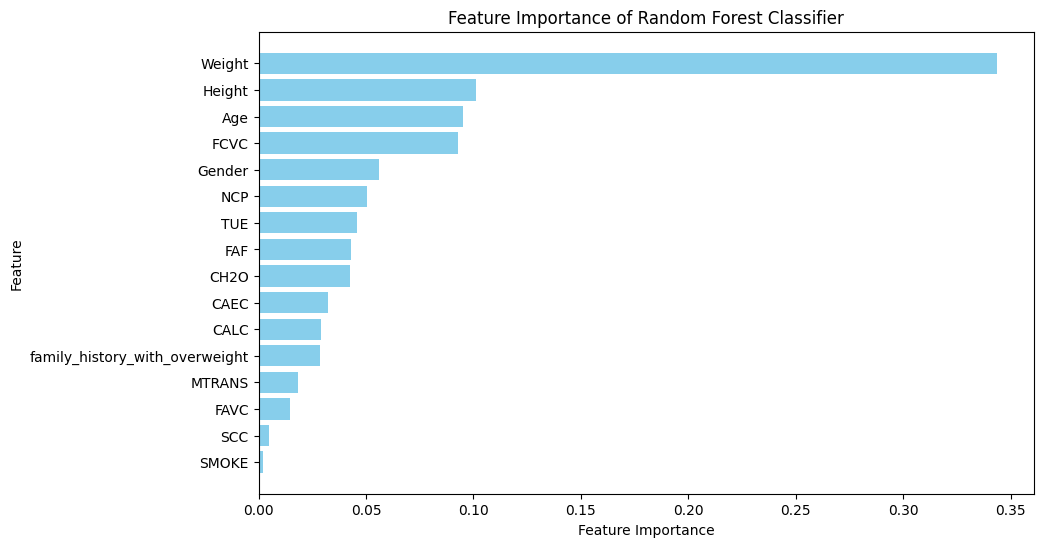

In [5]:
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required to be at a leaf node
}

rf_clf = RandomForestClassifier(random_state=seed)

grid_search = GridSearchCV(estimator=rf_clf, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Random Forest Classifier\n")
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

y_pred_rf = grid_search.predict(X_test)

print("Accuracy:\n",accuracy_score(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))
print("\nConfusion Matrix:\n",confusion_matrix(y_test, y_pred_rf))


best_rf_clf = grid_search.best_estimator_
feature_importance = pd.DataFrame(best_rf_clf.feature_importances_, index=X.columns, columns=['Importance']).sort_values('Importance', ascending=False)
feature_importance_asc = feature_importance.sort_values('Importance', ascending=True)
print("\nFeature Importance:\n", feature_importance)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_asc.index, feature_importance_asc['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance of Random Forest Classifier')
plt.show()

#### Method 3: Support Vector Machine

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
Best Score: 0.9512551534585432

SVM Classifier

Accuracy: 0.9794952681388013

Classification Report:
                      precision    recall  f1-score   support

Insufficient_Weight       0.97      1.00      0.98        86
      Normal_Weight       1.00      0.97      0.98        93
     Obesity_Type_I       0.99      0.97      0.98       102
    Obesity_Type_II       0.97      1.00      0.98        88
   Obesity_Type_III       1.00      0.99      0.99        98
 Overweight_Level_I       0.98      0.97      0.97        88
Overweight_Level_II       0.95      0.96      0.96        79

           accuracy                           0.98       634
          macro avg       0.98      0.98      0.98       634
       weighted avg       0.98      0.98      0.98       634


Confusion Matrix:
 [[86  0  0  0  0  0  0]
 [ 3 90  0  0  0  0  0]
 [ 0  0 99  2  0  0  1]
 [ 0 

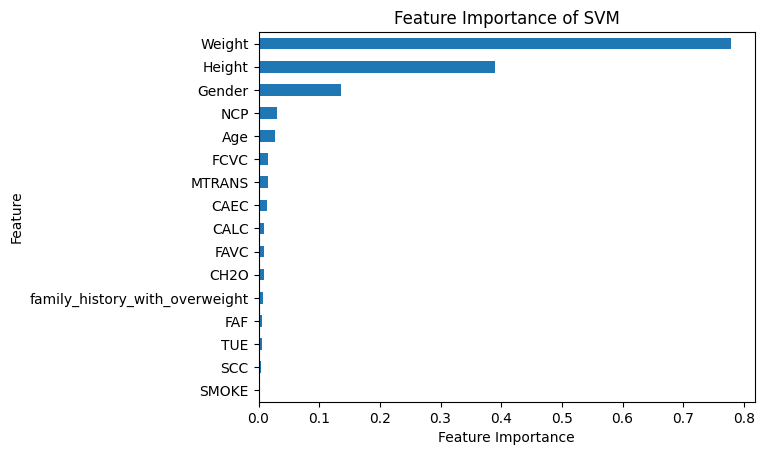

In [6]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],  # Regularization parameter
    'kernel': ['linear', 'rbf'],  # Kernel type
    'gamma': ['scale', 'auto']  # Kernel coefficient for 'rbf' kernel
}

svm_clf = SVC(random_state=seed)

grid_search = GridSearchCV(estimator=svm_clf, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

best_svm_clf = grid_search.best_estimator_
y_pred_svm = best_svm_clf.predict(X_test)

print("\nSVM Classifier\n")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("\nClassification Report:\n", classification_report(y_test, y_pred_svm))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_svm))

result_svr = permutation_importance(best_svm_clf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
sorted_idx = result_svr.importances_mean
feat_names = list(X.columns)

importance = pd.DataFrame(sorted_idx, index=feat_names, columns=['Importance'])
importance.sort_values(by='Importance', ascending=True).plot(kind='barh', title='Feature Importance of SVM', legend=False)
plt.ylabel('Feature')
plt.xlabel('Feature Importance')
plt.show()

#### Method 4: Neural Network

Epoch 1/50


c:\Users\epitt\miniconda3\envs\stat\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.2635 - loss: 1.8225 - val_accuracy: 0.5608 - val_loss: 1.3166
Epoch 2/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5453 - loss: 1.2786 - val_accuracy: 0.6588 - val_loss: 0.9912
Epoch 3/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6527 - loss: 0.9829 - val_accuracy: 0.7264 - val_loss: 0.7962
Epoch 4/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7590 - loss: 0.7912 - val_accuracy: 0.7838 - val_loss: 0.6629
Epoch 5/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8090 - loss: 0.6546 - val_accuracy: 0.8176 - val_loss: 0.5659
Epoch 6/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8300 - loss: 0.5534 - val_accuracy: 0.8480 - val_loss: 0.4909
Epoch 7/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8632 - loss: 0.4737 - val_accuracy: 0.8750 - val_loss: 0.4326
Epoch 8/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8922 - loss: 0.4096 - val_accuracy: 0.8919 - val_loss: 0.3866
Epo

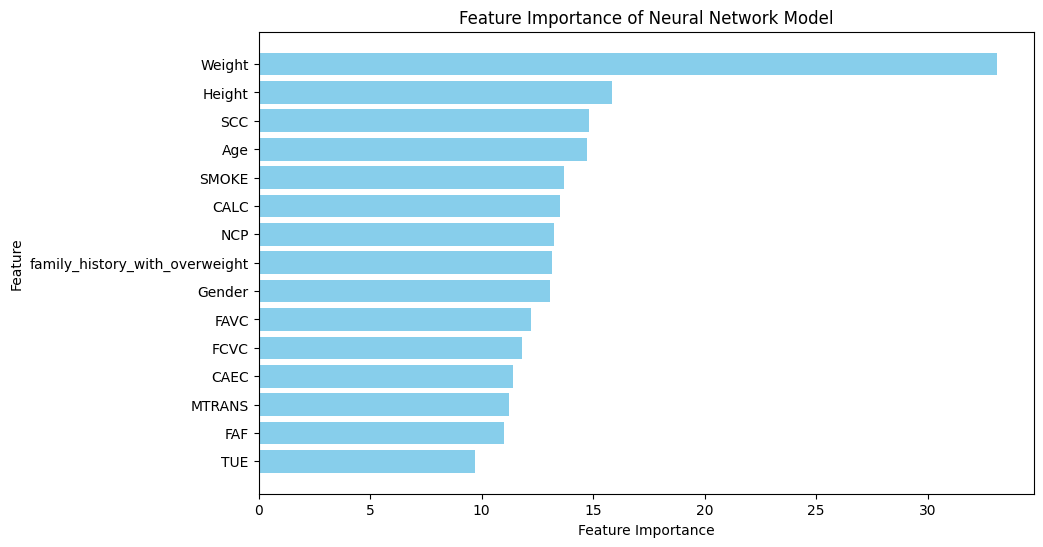

In [7]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

y_train_onehot = to_categorical(y_train_encoded)

model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(len(label_encoder.classes_), activation='softmax')) 
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, y_train_onehot, epochs=50, batch_size=16, validation_split=0.2, verbose=1)

y_pred_nn = model.predict(X_test)
y_pred_nn_classes = y_pred_nn.argmax(axis=1)
y_test_encoded = label_encoder.transform(y_test)
print("\nNeural Network\n")
print("\nAccuracy:", accuracy_score(y_test_encoded, y_pred_nn_classes))
print("\nClassification Report:\n", classification_report(y_test_encoded, y_pred_nn_classes))
print("\nConfusion Matrix:\n", confusion_matrix(y_test_encoded, y_pred_nn_classes))

weights = model.layers[0].get_weights()[0]

feature_importance = abs(weights).sum(axis=1)

feature_names = X.columns

sorted_indices = feature_importance.argsort()[::-1]
sorted_feature_importance = feature_importance[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names[:15], sorted_feature_importance[:15], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance of Neural Network Model')
plt.gca().invert_yaxis() 
plt.show()